In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

In [2]:
from PIL import Image

In [158]:
script_name = '2021-01-19-Autoencoder-v4b'

In [3]:
if not os.path.exists("image_names.txt"):
    names = open("image_names.txt", "w")
    img_names = os.listdir('../ALLSTIMULI')
    print('EXCLUDED:')
    for i in range(len(img_names)):
        if '2218506905' in img_names[i] or 'Data2' in img_names[i] \
            or 'Data3' in img_names[i] or 'Data4' in img_names[i] \
            or 'DS_' in img_names[i] or len(img_names[i])<=10\
            or 'i24622350' in img_names[i]:
            print(img_names[i])
        else:
            names.write(img_names[i][:-5]+'\n')
    names.close()
    
names = open("image_names.txt", "r")
img_names = names.readlines()
for i in range(len(img_names)):
    img_names[i]=img_names[i][:-1]

In [4]:
loc_data_xy={}
for name in img_names:
    locpath_train = '../data/loc_data/train/' + name
    locpath_test = '../data/loc_data/test/' + name
    try:
        f = open(locpath_train,'rb')
    except:
        f = open(locpath_test,'rb')
    loc_dict = pickle.load(f)
    loc_data_xy[name] = np.array(loc_dict['barycenters'])

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    #plt.pause(0.001)  # pause a bit so that plots are updated

# Dataset class

In [6]:
class SaccadeLandmarksDataset(Dataset):
    """Saccade Landmarks dataset."""

    def __init__(self, loc_dict, img_dir, img_names, transform=None):
        """
        Args:
            loc_dict (dict): Dictonary containing saccade coordinates
            img_dir (string): Directory with all the images.
            img_names (lost): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.loc_dict = loc_dict
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.loc_dict)

    def __getitem__(self, idx):

        #img_name = os.listdir(self.img_dir)[idx+2]
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name + '.jpeg')
        image = io.imread(img_path)
        #name = img_name[:-5]
        landmarks = self.loc_dict[name]
        landmarks = np.array([landmarks])
        landmarks = landmarks.reshape(-1, 2) #.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'name':name}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Transforms

In [7]:
class RandomSaccadeTo(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        nb_sac = len(landmarks)
        sac_num =  np.random.randint(nb_sac)
        sac = landmarks[sac_num]
        N_X, N_Y = image.shape[:2]
        #img_color_sac = saccade_to(image, (N_X//2, N_Y//2), (sac[1], sac[0]))
        image_roll = np.copy(image)
        image_roll=np.roll(image_roll, N_X//2 - sac[1], axis=0)
        image_roll=np.roll(image_roll, N_Y//2 - sac[0], axis=1)
        return {'image':image_roll, 'pos':sac, 'name':sample['name']}

In [8]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_tens = sample['image'].transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image_tens), 'pos': sample['pos'],  'name':sample['name']}

### Adapted cropped pyramid (squeezed tensor)

In [9]:
from PYramid import cropped_pyramid

lg shape= 32 32


In [10]:
class CroppedPyramid(object):
    def __init__(self, width, base_levels, color=True, do_mask=False, verbose=False):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
    
    def __call__(self, sample):
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True)
        #img_crop[:,-1,...]-=128 # on residual (!!)
        return{'img_crop':img_crop, 'level_size':level_size, 'pos':sample['pos'],  'name':sample['name']}
        
    

### LogGaborTransform

In [11]:
width=32
base_levels=2

In [12]:
from LogGabor import LogGabor
from PYramid import local_filter
from PYramid import get_K
from PYramid import log_gabor_transform

In [13]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2

pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)
K = get_K(width=width,
            n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
                  n_theta = n_theta,
                  n_phase = n_phase, 
                  r_min = width/6, 
                  r_max = width/3, 
                  log_density_ratio = 2, 
                  verbose=False)

In [14]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=True, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, sample):
        log_gabor_coeffs = log_gabor_transform(sample['img_crop'].unsqueeze(0), K)
        
        return{'img_gabor':log_gabor_coeffs, 'pos':sample['pos'],  'name':sample['name']}

### ComplexModulus

# Compose transforms
### transforms.Compose

In [15]:
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels)]) #, LogGaborTransform()])

In [16]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../ALLSTIMULI/',
                                          img_names=img_names,
                                          transform=composed_transform)

# Iterating through the dataset

In [17]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    for level in range(5,0,-1):
        plt.figure()
        images_batch = torch.clone(sample_batched['img_crop'][:,level,:,:,:])
        if level < 5:
            images_batch+=128  
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        #grid += 128
        plt.imshow(grid.numpy().transpose((1, 2, 0)).clip(0,255).astype('uint8'))

        plt.title('Batch from dataloader, level=' + str(level))


0 torch.Size([4, 6, 3, 32, 32])
0 ['i1427114536', 'i1425513894', 'i2200082985', 'i127442050']
1 torch.Size([4, 6, 3, 32, 32])
1 ['i2264595399', 'i2155306779', 'i130736782', 'i2265609722']
2 torch.Size([4, 6, 3, 32, 32])
2 ['i2272909117', 'i1199505141', 'i1815291162', 'i2291750140']
3 torch.Size([4, 6, 3, 32, 32])
3 ['i2210396651', 'istatic_submitted_saxena_chung_ng_nips2005_learningdepth_img_math14_p_313t0', 'i1246347137', 'i1870142757']


<Figure size 432x288 with 0 Axes>

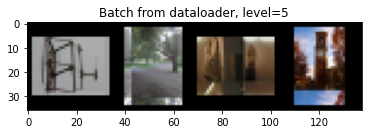

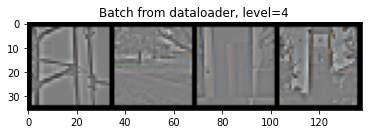

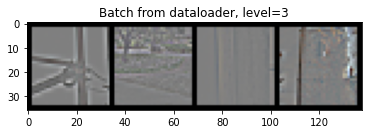

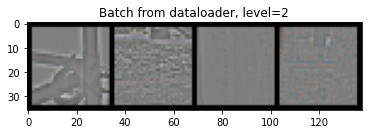

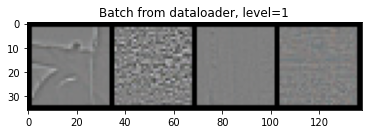

In [18]:
dataloader = DataLoader(saccade_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['img_crop'].size())
    print(i_batch, sample_batched['name'])
    if i_batch ==3 :
        plt.figure()
        show_landmarks_batch(sample_batched)  
        break
        

## Inverse LogGabor mapper

In [19]:
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels)]) #, 
                               #LogGaborTransform()])

In [20]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../ALLSTIMULI/',
                                          img_names=img_names,
                                          transform=composed_transform)

In [21]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2
n_levels = 6 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
n_eccentricity = 2
n_color = 3

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, n_eccentricity, n_azimuth, n_theta, n_phase, out_chan = 30):
        super(AutoEncoder, self).__init__()
        self.n_levels = n_levels
        self.n_color = n_color
        self.in_chan = n_eccentricity * n_azimuth * n_theta * n_phase
        self.out_chan = out_chan
        self.encoder = Encoder(in_chan=self.in_chan, out_chan=self.out_chan)
        self.decoder = Decoder(in_chan=self.out_chan, out_chan=self.in_chan)

    def forward(self, x, **kargs):        
        enc_input = x.view(-1, self.in_chan) / 256 # !!
        code = self.encoder(enc_input)
        return self.decoder(code) * 256 # !!

In [23]:
class Encoder(nn.Module):
    """ Encoder
    """
    def __init__(self, in_chan, out_chan):
        super(Encoder, self).__init__()
        self.enc = nn.Linear(in_chan, out_chan)
            
    def forward(self, x):
        return self.enc(x)

In [24]:
class Decoder(nn.Module):
    """ Decoder
    """
    def __init__(self, in_chan, out_chan):
        super(Decoder, self).__init__()
        self.dec = nn.Linear(in_chan, out_chan)
            
    def forward(self, x):
        return self.dec(x)

In [25]:
class InverseLogGaborMapper(nn.Module):
    def __init__(self, in_chan = n_eccentricity * n_azimuth * n_theta * n_phase, 
                 out_chan = width * width):
        super(InverseLogGaborMapper, self).__init__()
        self.inverseMap = nn.Linear(in_chan, out_chan)
        
    def forward(self, x, **kargs):
        out = self.inverseMap(x/256) #!!
        return out*256 #!!

In [ ]:
### Model and learning params

In [26]:
out_chan = 100

batch_size=15
autoenc_lr = 3e-4
invLG_lr = 3e-5

n_epoch = 1000
recording_steps = 10

In [27]:
autoenc = []        
for i in range(n_levels):
    autoenc.append(AutoEncoder(n_eccentricity, n_azimuth, n_theta, n_phase, out_chan=out_chan))

invLGmap = InverseLogGaborMapper()

In [28]:
autoenc_optimizer = []        
for i in range(n_levels):
    autoenc_optimizer.append(optim.Adam(autoenc[i].parameters(), lr = autoenc_lr))
        
invLG_optimizer = optim.Adam(invLGmap.parameters(), lr = invLG_lr)

criterion = nn.MSELoss() #loss = criterion(outputs, inputs)

In [29]:
dataloader = DataLoader(saccade_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [30]:
autoenc_loss_list = []
invLG_loss_list = []

In [68]:

PATH = script_name + '_invLGmap.pt'
if True: #not os.path.exists(PATH):    

    for epoch in range(n_epoch):  # loop over the dataset multiple times

        autoenc_running_loss = 0.0
        invLG_running_loss = 0.0
        for step, data in enumerate(dataloader):

            batch_size_eff = data['img_crop'].shape[0]

            autoenc_inputs = log_gabor_transform(data['img_crop'], K)
            #autoenc_inputs = 

            # zero the parameter gradients
            autoenc_outputs = []    
            for i in range(n_levels):

                autoenc_optimizer[i].zero_grad()
                level_inputs = autoenc_inputs[:,i,...].reshape(batch_size_eff * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
                level_outputs = autoenc[i](level_inputs)                
                autoenc_loss = criterion(level_outputs, level_inputs)
                autoenc_loss.backward()
                autoenc_optimizer[i].step()
                autoenc_outputs.append(level_outputs.view(batch_size_eff, n_color, n_eccentricity, n_azimuth, n_theta, n_phase))

            autoenc_outputs = torch.stack(autoenc_outputs, dim=1) 
            #print(autoenc_outputs.shape)

            invLG_optimizer.zero_grad()

            invLGmap_inputs = autoenc_outputs.detach().view(batch_size_eff * n_levels * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
            img_pyr_rec_rec = invLGmap(invLGmap_inputs).view(batch_size_eff, n_levels, n_color, width, width)
            img_pyr_rec_rec[:,-1,...] += 128 # !! on residuals only!!

            img_pyr_rec_rec = img_pyr_rec_rec.view(batch_size_eff * n_levels * n_color, width * width)
            img_pyr_targets = data['img_crop'].view(batch_size_eff * n_levels * n_color, width * width)
            invLG_loss = criterion(img_pyr_rec_rec, img_pyr_targets)
            invLG_loss.backward()             
            invLG_optimizer.step()

            # print statistics
            autoenc_running_loss += autoenc_loss.item()
            invLG_running_loss += invLG_loss.item()
            if (step+1)%recording_steps == 0 :    # print every n_steps mini-batches
                print('[%d, %5d] losses: %.3f, %.3f' %
                      (epoch + 1, step + 1, autoenc_running_loss/recording_steps, 
                                         invLG_running_loss/recording_steps))
                #.append
                autoenc_loss_list.append(autoenc_running_loss/recording_steps)
                autoenc_running_loss = 0.0
                invLG_loss_list.append(invLG_running_loss/recording_steps)
                invLG_running_loss = 0.0

    print('Finished Training ')
    
    torch.save(invLGmap, PATH)
    for level in range(n_levels):
        PATH = script_name + '_autoencoder_level_' + str(level) +'.pt'
        torch.save(autoenc[level], PATH)
        
    print('Model saved')

else:
    invLGmap = torch.load(PATH)
    for level in range(levels):
        PATH = script_name + '_autoencoder_level_' + str(level) +'.pt'
        autoenc[level] = torch.load(PATH)

[1,    10] losses: 1184.296, 965.195
[1,    20] losses: 1143.748, 1021.537
[1,    30] losses: 1185.229, 1071.060
[1,    40] losses: 1028.164, 946.690
[1,    50] losses: 1081.596, 1006.947
[1,    60] losses: 1103.000, 997.089
[2,    10] losses: 1126.871, 1073.700
[2,    20] losses: 1203.473, 989.832
[2,    30] losses: 1047.937, 1006.878
[2,    40] losses: 1067.371, 942.830
[2,    50] losses: 1155.371, 1034.677
[2,    60] losses: 1098.959, 993.858
[3,    10] losses: 1102.184, 986.558
[3,    20] losses: 1156.757, 965.459
[3,    30] losses: 1108.415, 1062.790
[3,    40] losses: 1027.030, 951.562
[3,    50] losses: 1154.980, 1051.960
[3,    60] losses: 1099.930, 1004.622
[4,    10] losses: 1195.065, 1077.327
[4,    20] losses: 1067.172, 976.264
[4,    30] losses: 1110.638, 1041.599
[4,    40] losses: 1067.281, 1026.618
[4,    50] losses: 1095.638, 989.521
[4,    60] losses: 1095.501, 949.213
[5,    10] losses: 1011.016, 1050.621
[5,    20] losses: 1080.693, 976.775
[5,    30] losses: 1083.2

[37,    40] losses: 890.191, 949.187
[37,    50] losses: 1039.644, 940.620
[37,    60] losses: 989.277, 943.437
[38,    10] losses: 895.794, 931.891
[38,    20] losses: 1008.520, 977.430
[38,    30] losses: 970.229, 961.870
[38,    40] losses: 1002.858, 977.984
[38,    50] losses: 954.844, 929.251
[38,    60] losses: 976.240, 974.865
[39,    10] losses: 965.627, 922.838
[39,    20] losses: 975.568, 952.880
[39,    30] losses: 929.808, 965.842
[39,    40] losses: 946.518, 920.603
[39,    50] losses: 998.246, 893.971
[39,    60] losses: 962.078, 914.776
[40,    10] losses: 977.325, 922.434
[40,    20] losses: 850.269, 884.920
[40,    30] losses: 1027.146, 967.063
[40,    40] losses: 987.505, 943.715
[40,    50] losses: 1006.698, 925.473
[40,    60] losses: 991.111, 964.335
[41,    10] losses: 952.566, 911.078
[41,    20] losses: 1007.122, 868.488
[41,    30] losses: 1029.366, 1036.412
[41,    40] losses: 981.367, 929.717
[41,    50] losses: 962.857, 946.006
[41,    60] losses: 970.206, 1

[74,    30] losses: 949.724, 959.353
[74,    40] losses: 970.211, 904.056
[74,    50] losses: 924.141, 874.433
[74,    60] losses: 952.778, 893.979
[75,    10] losses: 982.240, 877.975
[75,    20] losses: 1022.698, 892.467
[75,    30] losses: 946.321, 909.218
[75,    40] losses: 911.068, 900.723
[75,    50] losses: 897.297, 957.161
[75,    60] losses: 977.466, 941.644
[76,    10] losses: 918.223, 880.966
[76,    20] losses: 993.320, 861.883
[76,    30] losses: 997.706, 915.338
[76,    40] losses: 910.818, 920.055
[76,    50] losses: 974.116, 957.186
[76,    60] losses: 961.333, 899.484
[77,    10] losses: 959.462, 921.957
[77,    20] losses: 1065.872, 928.991
[77,    30] losses: 917.013, 857.914
[77,    40] losses: 942.456, 887.646
[77,    50] losses: 950.774, 934.722
[77,    60] losses: 931.481, 921.161
[78,    10] losses: 953.195, 865.608
[78,    20] losses: 996.470, 901.776
[78,    30] losses: 961.870, 944.382
[78,    40] losses: 877.609, 876.104
[78,    50] losses: 1030.699, 996.40

[110,    60] losses: 1022.341, 912.079
[111,    10] losses: 983.856, 869.474
[111,    20] losses: 933.332, 853.820
[111,    30] losses: 951.246, 873.523
[111,    40] losses: 930.139, 874.351
[111,    50] losses: 913.487, 956.755
[111,    60] losses: 1025.319, 896.491
[112,    10] losses: 920.599, 848.185
[112,    20] losses: 961.183, 869.623
[112,    30] losses: 934.999, 923.459
[112,    40] losses: 965.303, 867.926
[112,    50] losses: 989.144, 858.367
[112,    60] losses: 910.999, 908.526
[113,    10] losses: 988.539, 915.547
[113,    20] losses: 961.424, 902.520
[113,    30] losses: 882.865, 849.580
[113,    40] losses: 996.203, 887.773
[113,    50] losses: 947.155, 884.576
[113,    60] losses: 908.906, 867.830
[114,    10] losses: 1045.005, 945.737
[114,    20] losses: 886.209, 868.259
[114,    30] losses: 958.872, 876.242
[114,    40] losses: 945.811, 895.975
[114,    50] losses: 989.588, 856.486
[114,    60] losses: 973.662, 901.694
[115,    10] losses: 906.187, 907.427
[115,    

[146,    50] losses: 945.371, 902.248
[146,    60] losses: 898.067, 856.117
[147,    10] losses: 927.812, 890.115
[147,    20] losses: 929.081, 910.734
[147,    30] losses: 988.848, 863.489
[147,    40] losses: 980.808, 884.393
[147,    50] losses: 902.385, 864.566
[147,    60] losses: 902.127, 808.468
[148,    10] losses: 932.496, 892.944
[148,    20] losses: 993.140, 888.324
[148,    30] losses: 974.503, 910.004
[148,    40] losses: 914.657, 839.627
[148,    50] losses: 925.887, 859.338
[148,    60] losses: 948.414, 878.305
[149,    10] losses: 993.251, 874.694
[149,    20] losses: 977.531, 872.123
[149,    30] losses: 904.232, 785.551
[149,    40] losses: 885.180, 835.858
[149,    50] losses: 924.046, 852.010
[149,    60] losses: 996.348, 875.944
[150,    10] losses: 889.857, 874.129
[150,    20] losses: 1012.226, 864.362
[150,    30] losses: 923.124, 854.581
[150,    40] losses: 978.531, 872.666
[150,    50] losses: 941.444, 895.249
[150,    60] losses: 956.234, 877.159
[151,    10

[182,    40] losses: 931.302, 862.577
[182,    50] losses: 972.187, 873.365
[182,    60] losses: 920.033, 936.245
[183,    10] losses: 934.559, 873.897
[183,    20] losses: 984.709, 828.308
[183,    30] losses: 888.397, 861.862
[183,    40] losses: 945.303, 827.358
[183,    50] losses: 970.118, 823.711
[183,    60] losses: 964.866, 846.864
[184,    10] losses: 910.304, 841.156
[184,    20] losses: 877.771, 828.016
[184,    30] losses: 983.555, 852.936
[184,    40] losses: 1015.450, 868.205
[184,    50] losses: 929.688, 871.836
[184,    60] losses: 884.784, 899.692
[185,    10] losses: 921.975, 841.606
[185,    20] losses: 977.552, 847.793
[185,    30] losses: 949.091, 857.379
[185,    40] losses: 951.565, 831.661
[185,    50] losses: 932.770, 883.793
[185,    60] losses: 897.047, 853.280
[186,    10] losses: 954.628, 914.739
[186,    20] losses: 982.957, 852.322
[186,    30] losses: 954.821, 900.832
[186,    40] losses: 968.770, 852.712
[186,    50] losses: 978.508, 846.853
[186,    60

[218,    40] losses: 968.334, 801.601
[218,    50] losses: 933.035, 817.946
[218,    60] losses: 948.368, 869.475
[219,    10] losses: 945.254, 852.563
[219,    20] losses: 979.069, 854.423
[219,    30] losses: 929.306, 851.765
[219,    40] losses: 969.748, 824.301
[219,    50] losses: 942.642, 825.741
[219,    60] losses: 937.694, 904.282
[220,    10] losses: 932.942, 819.688
[220,    20] losses: 957.619, 828.953
[220,    30] losses: 974.763, 827.634
[220,    40] losses: 970.397, 847.580
[220,    50] losses: 888.639, 867.671
[220,    60] losses: 946.630, 835.909
[221,    10] losses: 984.139, 862.584
[221,    20] losses: 880.768, 832.667
[221,    30] losses: 895.096, 804.518
[221,    40] losses: 891.217, 824.326
[221,    50] losses: 967.653, 816.365
[221,    60] losses: 1044.719, 870.712
[222,    10] losses: 899.895, 855.883
[222,    20] losses: 925.573, 796.577
[222,    30] losses: 947.784, 862.465
[222,    40] losses: 974.134, 860.010
[222,    50] losses: 924.197, 784.613
[222,    60

[254,    40] losses: 1010.974, 824.651
[254,    50] losses: 952.610, 848.673
[254,    60] losses: 899.307, 778.676
[255,    10] losses: 946.161, 830.773
[255,    20] losses: 996.281, 841.048
[255,    30] losses: 986.937, 821.325
[255,    40] losses: 983.895, 844.059
[255,    50] losses: 835.566, 798.592
[255,    60] losses: 933.541, 829.863
[256,    10] losses: 976.516, 798.022
[256,    20] losses: 949.711, 844.978
[256,    30] losses: 1001.090, 845.700
[256,    40] losses: 860.215, 875.011
[256,    50] losses: 951.748, 811.647
[256,    60] losses: 950.333, 820.184
[257,    10] losses: 900.414, 839.678
[257,    20] losses: 965.089, 825.776
[257,    30] losses: 908.092, 820.762
[257,    40] losses: 958.485, 817.891
[257,    50] losses: 968.257, 839.982
[257,    60] losses: 1005.259, 824.619
[258,    10] losses: 922.415, 815.806
[258,    20] losses: 922.806, 840.749
[258,    30] losses: 893.346, 821.492
[258,    40] losses: 886.138, 782.835
[258,    50] losses: 1024.468, 886.461
[258,   

[290,    30] losses: 877.261, 824.446
[290,    40] losses: 928.622, 813.015
[290,    50] losses: 896.804, 849.063
[290,    60] losses: 993.287, 802.454
[291,    10] losses: 896.552, 776.552
[291,    20] losses: 937.785, 831.272
[291,    30] losses: 948.718, 830.201
[291,    40] losses: 970.148, 777.475
[291,    50] losses: 929.222, 843.529
[291,    60] losses: 956.931, 788.955
[292,    10] losses: 899.225, 833.428
[292,    20] losses: 952.447, 783.633
[292,    30] losses: 990.981, 830.722
[292,    40] losses: 949.303, 807.277
[292,    50] losses: 954.920, 789.639
[292,    60] losses: 873.727, 766.373
[293,    10] losses: 896.395, 777.626
[293,    20] losses: 959.605, 794.909
[293,    30] losses: 982.211, 846.902
[293,    40] losses: 962.816, 817.560
[293,    50] losses: 890.103, 795.801
[293,    60] losses: 985.310, 810.244
[294,    10] losses: 942.158, 778.599
[294,    20] losses: 1002.849, 843.355
[294,    30] losses: 950.279, 765.175
[294,    40] losses: 925.222, 832.953
[294,    50

[326,    30] losses: 921.450, 805.979
[326,    40] losses: 1028.532, 851.219
[326,    50] losses: 942.080, 817.458
[326,    60] losses: 962.052, 833.243
[327,    10] losses: 857.978, 795.410
[327,    20] losses: 906.007, 804.762
[327,    30] losses: 956.854, 827.053
[327,    40] losses: 881.051, 744.373
[327,    50] losses: 1011.845, 823.856
[327,    60] losses: 988.817, 845.097
[328,    10] losses: 963.550, 768.474
[328,    20] losses: 999.556, 809.452
[328,    30] losses: 925.435, 892.984
[328,    40] losses: 922.210, 873.690
[328,    50] losses: 868.909, 783.275
[328,    60] losses: 919.576, 776.841
[329,    10] losses: 876.951, 807.089
[329,    20] losses: 1032.697, 829.096
[329,    30] losses: 933.892, 751.866
[329,    40] losses: 850.025, 835.092
[329,    50] losses: 1025.913, 842.996
[329,    60] losses: 1007.286, 803.022
[330,    10] losses: 950.147, 796.016
[330,    20] losses: 990.426, 814.652
[330,    30] losses: 966.463, 770.657
[330,    40] losses: 975.267, 826.599
[330,  

KeyboardInterrupt: 

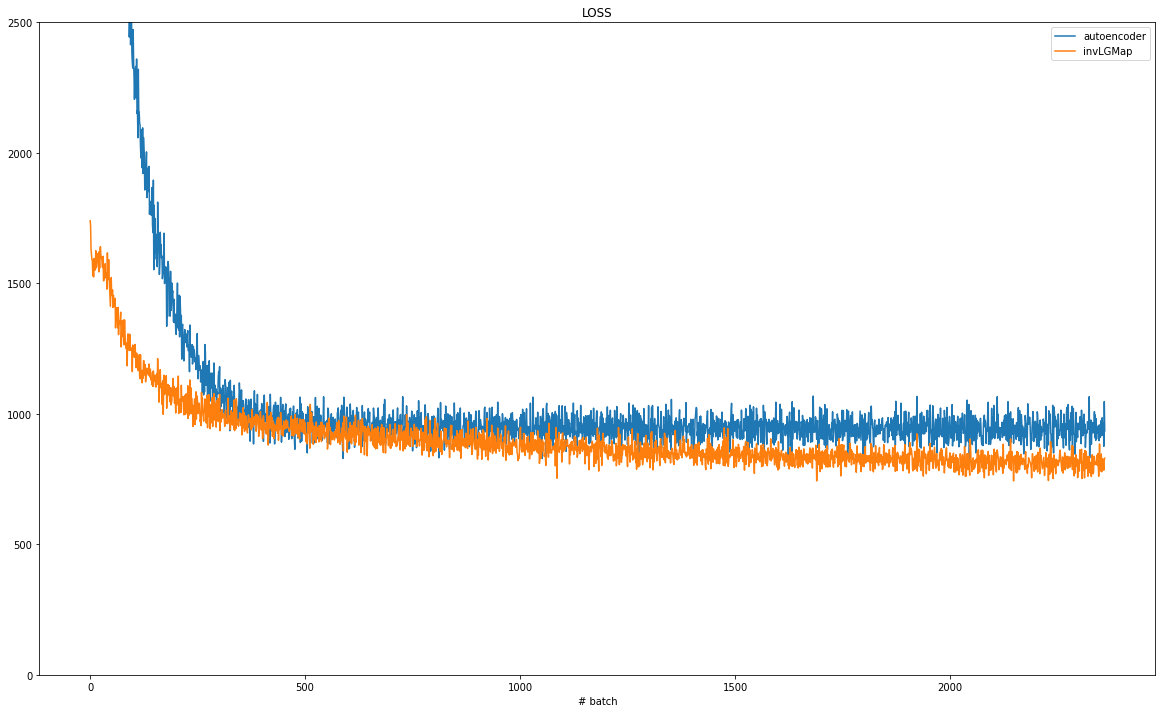

In [71]:
plt.figure(figsize=(20,12))
plt.plot(autoenc_loss_list, label = 'autoencoder')
plt.plot(np.array(invLG_loss_list), label = 'invLGMap')
plt.ylim(0,2500)
plt.title('LOSS')
plt.xlabel('# batch')
plt.legend()

## Encoding and decoding

In [141]:
locpath = '../ALLSTIMULI/' + img_names[500] + '.jpeg'
img_orig = Image.open(locpath)
img_tens = torch.Tensor(np.array(img_orig)[None,...]).permute(0,3,1,2)

In [142]:
img_crop = cropped_pyramid(img_tens, color=True, do_mask=True,verbose=True)[0]

Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [143]:
log_gabor_coeffs = log_gabor_transform(img_crop, K)
log_gabor_coeffs.shape

torch.Size([1, 6, 3, 2, 12, 12, 2])

In [144]:
autoenc_inputs = log_gabor_coeffs #.view(-1, n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase)

In [145]:
autoenc_outputs = []    
for i in range(n_levels):
    level_inputs = autoenc_inputs[:,i,...].reshape(n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
    level_outputs = autoenc[i](level_inputs)                
    autoenc_outputs.append(level_outputs.view(1, n_color, n_eccentricity, n_azimuth, n_theta, n_phase))

log_gabor_coeffs_rec = torch.stack(autoenc_outputs, dim=1) 

In [146]:
#log_gabor_coeffs_rec = autoenc.decoder.dec(code)
inv_LGmap_input = log_gabor_coeffs_rec.view(n_levels * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)
inv_LGmap_input.shape

torch.Size([18, 576])

In [147]:
#log_gabor_coeffs_rec = encoder_output.view(-1, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase)

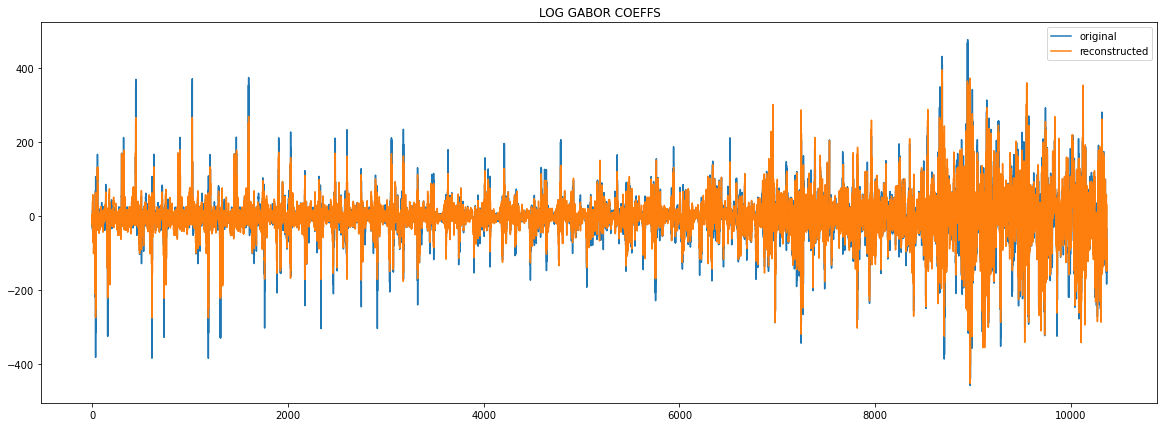

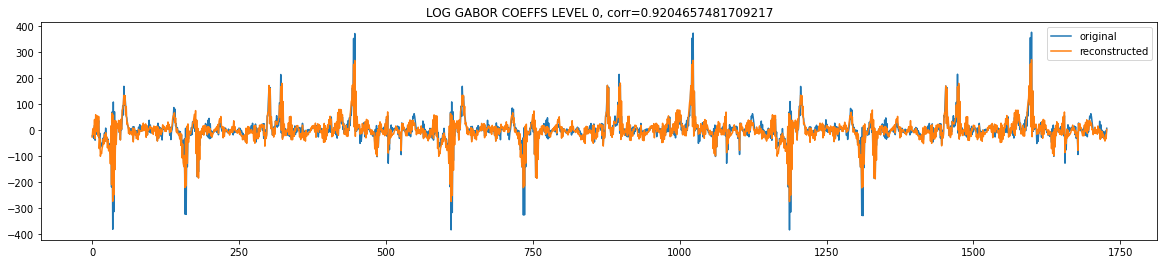

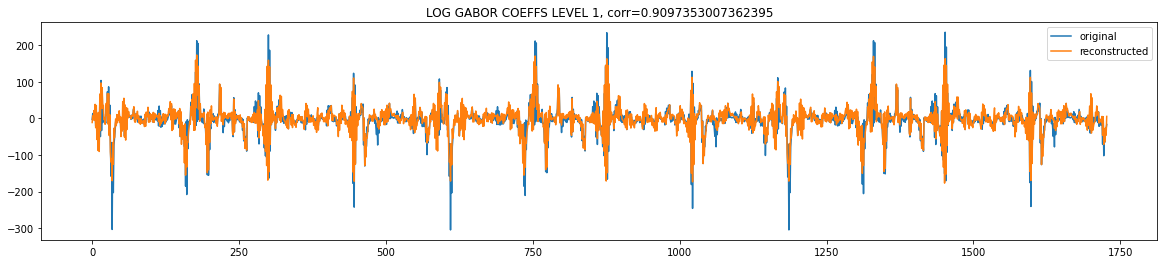

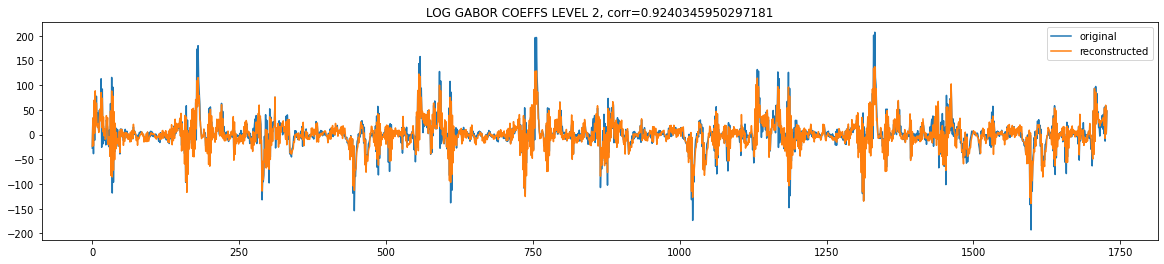

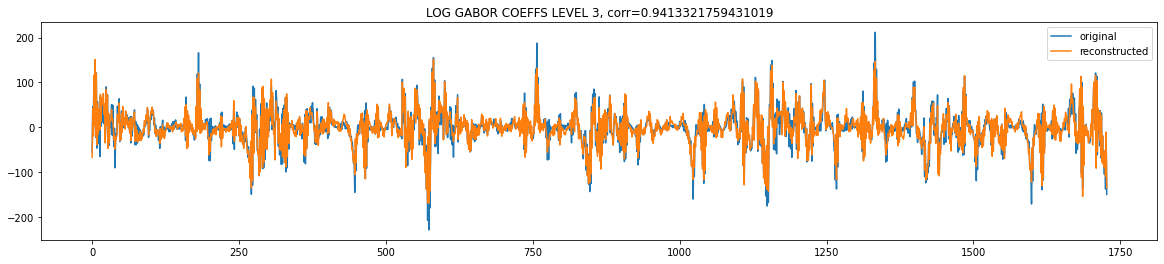

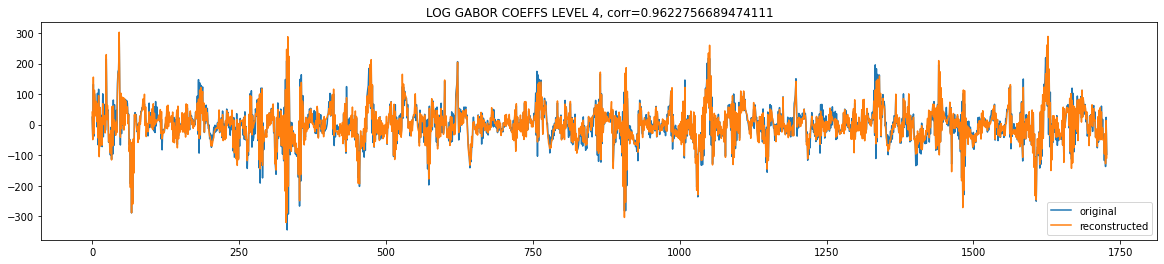

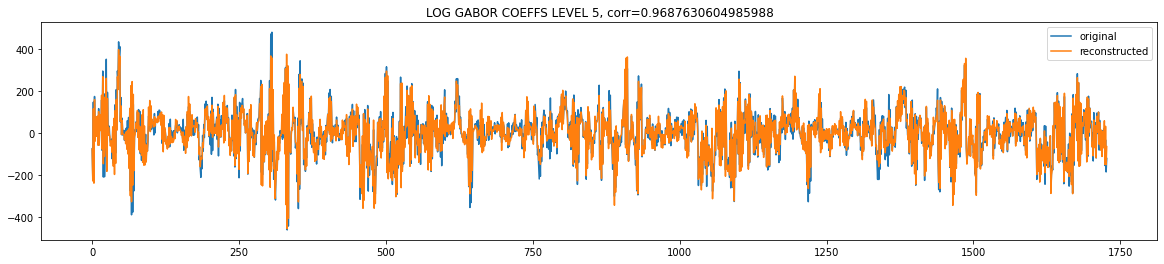

In [148]:
plt.figure(figsize=(20,7))
plt.plot(log_gabor_coeffs.numpy().flatten()[:], label = 'original')
plt.plot(log_gabor_coeffs_rec.detach().numpy().flatten()[:], label = 'reconstructed')
plt.title('LOG GABOR COEFFS')
plt.legend()
for level in range(n_levels):
    plt.figure(figsize=(20,4))
    plt.plot(log_gabor_coeffs[0,level,...].numpy().flatten(), label = 'original')
    plt.plot(log_gabor_coeffs_rec[0,level,...].detach().numpy().flatten(), label = 'reconstructed')
    c = np.corrcoef([log_gabor_coeffs[0,level,...].numpy().flatten(), log_gabor_coeffs_rec[0,level,...].detach().numpy().flatten()])[0,1]
    plt.title('LOG GABOR COEFFS LEVEL '+str(level)+', corr='+str(c))
    plt.legend()


### Image utilities

In [149]:
def tensor_pyramid_display(img_pyr_tens, global_bias = 0):
    fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
    img_aff = img_pyr_tens.permute(0,1,3,4,2).detach().numpy()
    for i_level, ax in enumerate(axs):
        if i_level < n_levels-1:
            bias = 128
        else:
            bias = global_bias
        ax.imshow((img_aff[0, i_level, ...]+bias).clip(0,255).astype('uint8'))
        ax.plot([width/2], [width/2], 'r+', ms=32);
    #print('Tensor shape=', img_rec.shape) 
    return axs

In [150]:
def tensor_image_cmp(img_tens_ref, img_tens_rec):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    img_aff_ref = img_tens_ref.detach().permute(0,2,3,1).squeeze().detach().numpy().clip(0,255).astype('uint8')
    ax[0].imshow(img_aff_ref)
    N_X, N_Y, _ = img_aff_ref.shape
    ax[0].plot([N_Y//2], [N_X//2], 'r+', ms=16)
    ax[0].set_title('LOG GABOR RECONSTRUCTION')
    img_aff_rec = img_tens_rec.detach().permute(0,2,3,1).squeeze().detach().numpy().clip(0,255).astype('uint8')
    ax[1].imshow(img_aff_rec)
    ax[1].plot([N_Y//2], [N_X//2], 'r+', ms=16)
    ax[1].set_title('AUTO-ENCODER RECONSTRUCTION')
    return ax

## Reconstruction tests

### Pyramid reconstruction

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([576, 1024])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])


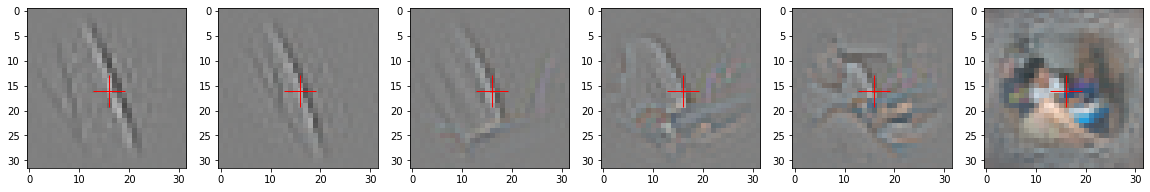

In [151]:
from PYramid import get_K_inv, inverse_gabor
K_inv = get_K_inv(K)
img_rec=inverse_gabor(log_gabor_coeffs.detach(), K_inv)
axs = tensor_pyramid_display(img_rec)

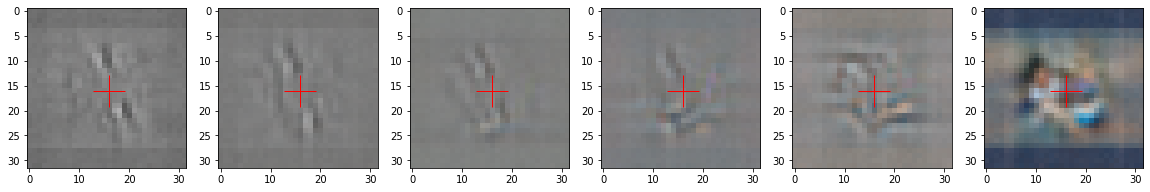

In [152]:
img_rec_rec = invLGmap(inv_LGmap_input) #inv_LGmap_input)
img_rec_rec = img_rec_rec.view(1, n_levels, n_color, width, width).detach()
img_rec_rec[0,-1,...] += 128
axs = tensor_pyramid_display(img_rec_rec, global_bias = 0)

### Test de invLGmap uniquement sur log gabor coeffs originaux

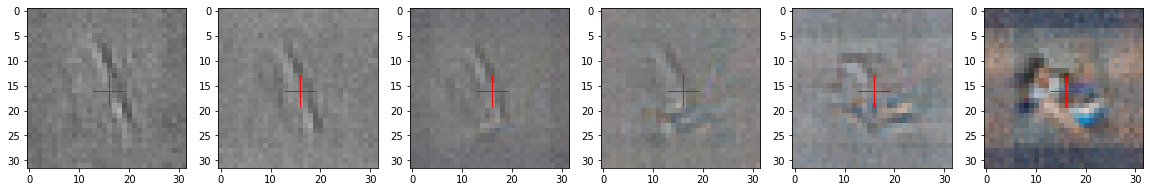

In [153]:
img_rec_test = invLGmap(log_gabor_coeffs.view(n_levels * n_color, n_eccentricity * n_azimuth * n_theta * n_phase)) #inv_LGmap_input)
img_rec_test = img_rec_test.view(1, n_levels, n_color, width, width).detach()
img_rec_test[0,-1,...] += 128
axs = tensor_pyramid_display(img_rec_test, global_bias = 0)

### Test des coeffs reconstruits avec differentes valeurs de K_inv 

Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])


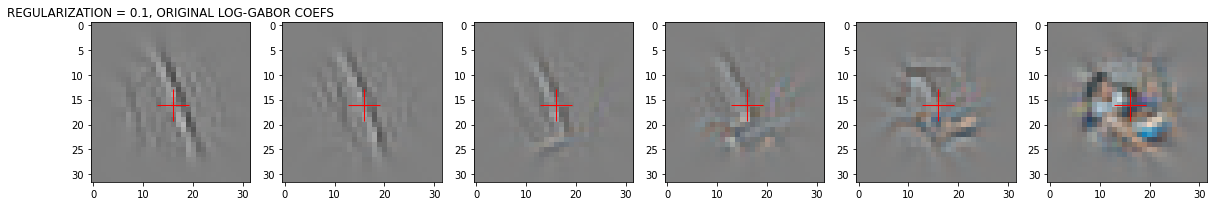

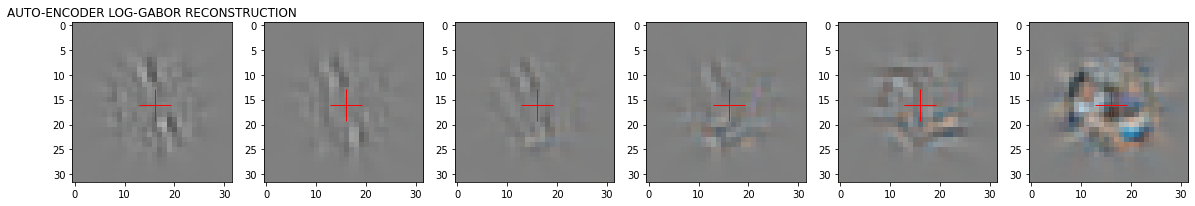

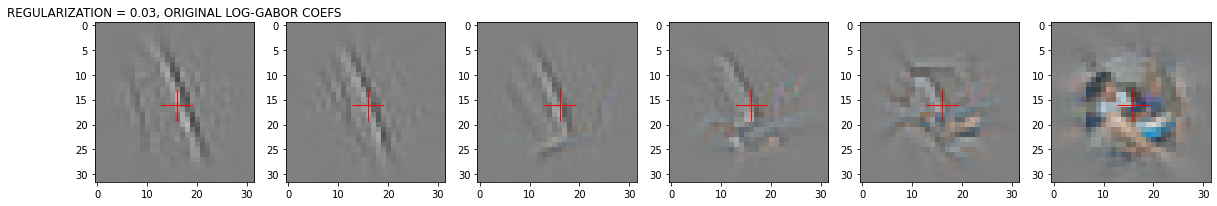

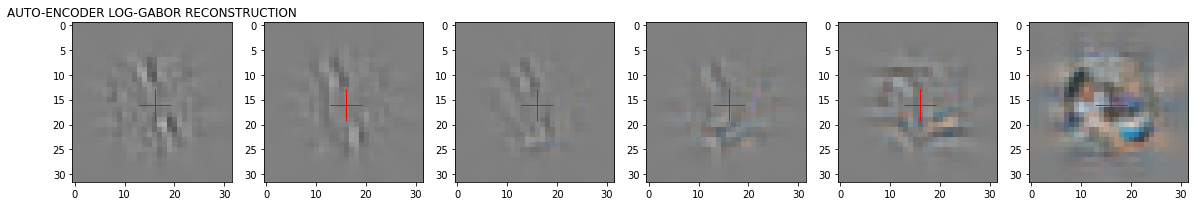

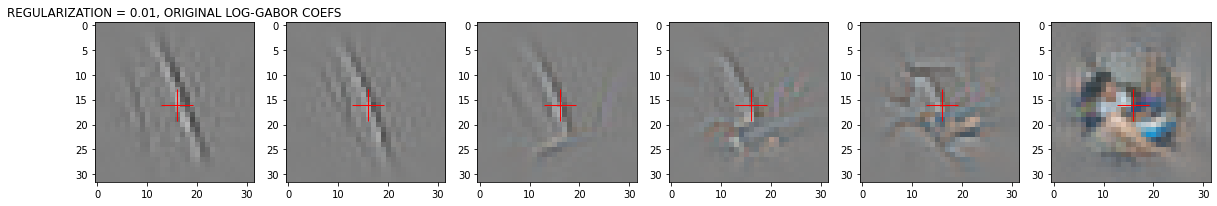

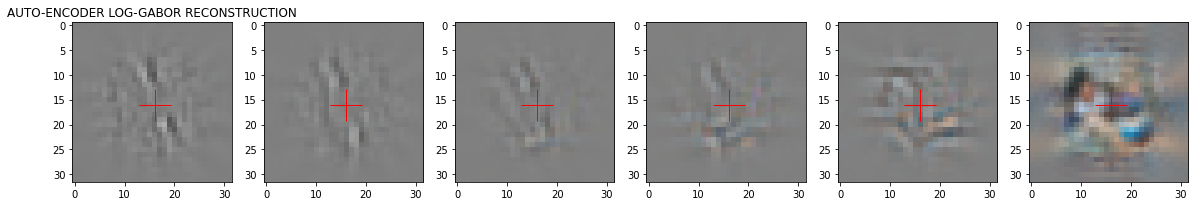

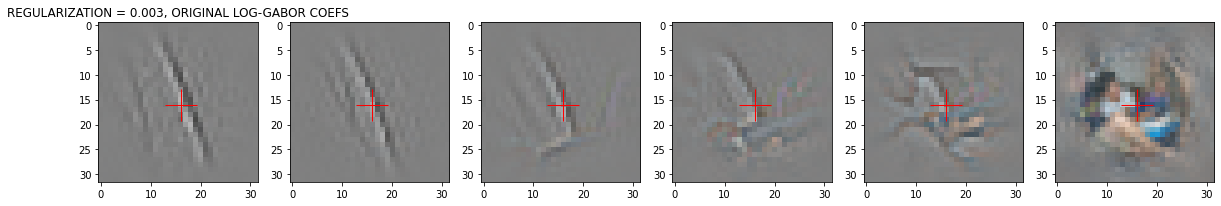

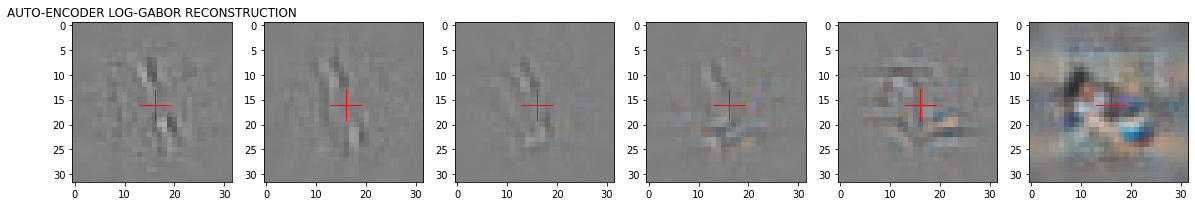

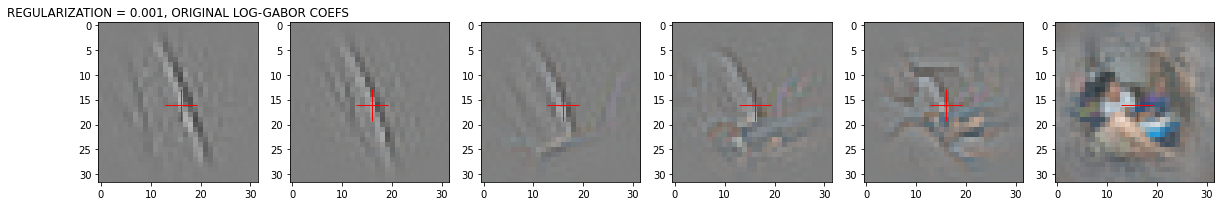

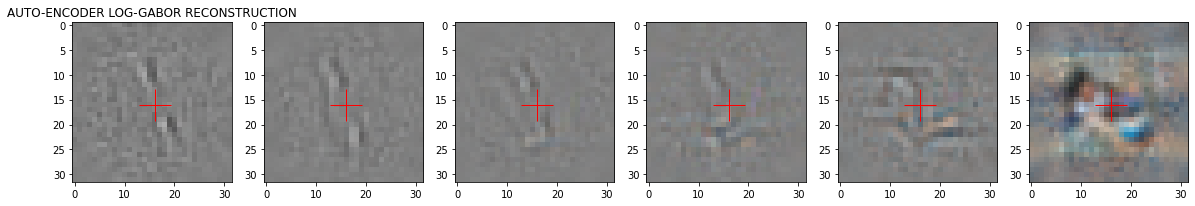

In [154]:
img_rec_rec_test = []
for i, rcond in enumerate((0.1, 0.03, 0.01, 0.003, 0.001)):
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    print('Reshaped filter tensor=', K_.shape)
    K_inv_test = torch.pinverse(K_, rcond=rcond) 
    print('Tensor shape=', K_inv.shape)
    K_inv_test =K_inv_test.reshape(n_sublevel, n_azimuth, n_theta, n_phase, width, width)
    img_rec_rcond_test = inverse_gabor(log_gabor_coeffs.detach(), K_inv_test)
    axs = tensor_pyramid_display(img_rec_rcond_test)
    axs[0].set_title('REGULARIZATION = '+str(rcond)+', ORIGINAL LOG-GABOR COEFS')
    img_rec_rec_test.append(inverse_gabor(inv_LGmap_input.view(1, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase), K_inv_test))
    axs = tensor_pyramid_display(img_rec_rec_test[i])
    axs[0].set_title('AUTO-ENCODER LOG-GABOR RECONSTRUCTION')    

### Full image reconstruction

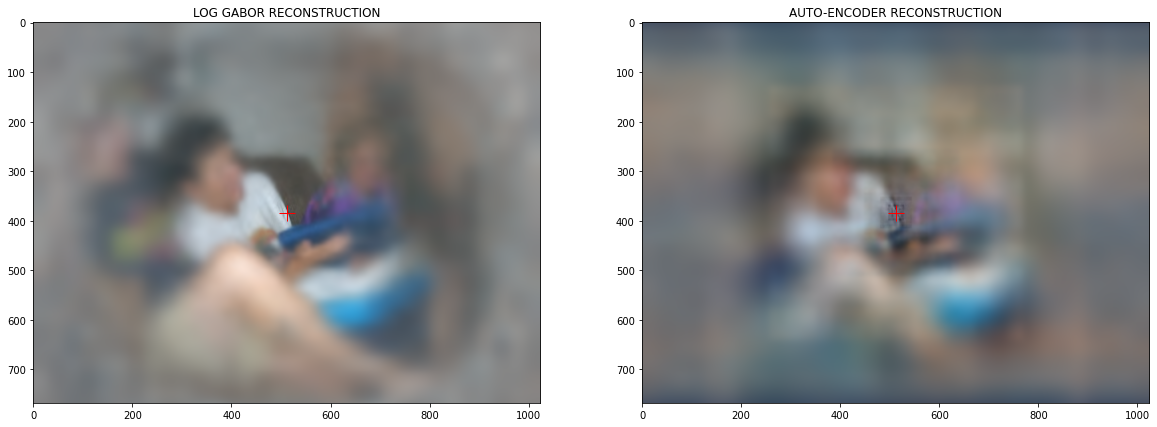

In [155]:
from PYramid import inverse_pyramid
full_img_rec = inverse_pyramid(img_rec, color=True)
#img_rec_rec[0,5,:,:,:]+=128
full_img_rec_rec = inverse_pyramid(img_rec_rec, color=True)
ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)


### Image from reconstructed log gabor coeffs only 

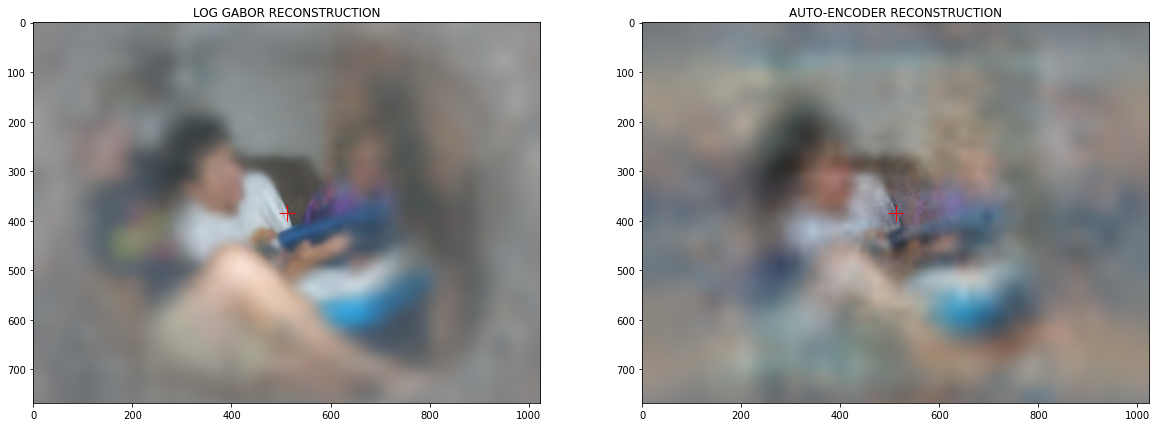

In [156]:
from PYramid import inverse_pyramid
full_img_rec = inverse_pyramid(img_rec, color=True)
#img_rec_rec[0,5,:,:,:]+=128
full_img_rec_rec = inverse_pyramid(img_rec_rec_test[4], color=True)
ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)


### Image from reconstructed inverted LP 

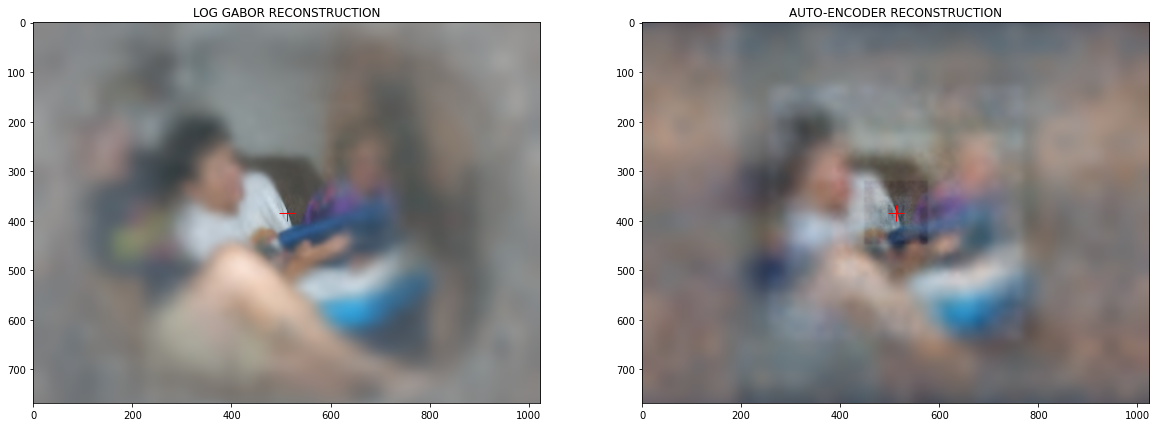

In [157]:
from PYramid import inverse_pyramid
full_img_rec = inverse_pyramid(img_rec, color=True)
#img_rec_rec[0,5,:,:,:]+=128
full_img_rec_rec = inverse_pyramid(img_rec_test, color=True)
ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)